In [1]:
import time
import seaborn as sns

import jax
import matplotlib.pyplot as plt
import optax
from orbax.checkpoint import PyTreeCheckpointer
from flax.training.train_state import TrainState

from lotf import LOTF_PATH
from lotf.algos import bptt
from lotf.envs import TrajTrackingStateEnv
from lotf.envs.wrappers import MinMaxObservationWrapper, LogWrapper, VecEnv
from lotf.modules import MLP
from lotf.objects import Quadrotor, RefTrajNames

# Training a Trajectory Tracking Policy With BPTT

## 1. Seed

In [2]:
seed = 0
key = jax.random.key(seed)
key_init, key_bptt = jax.random.split(key, 2)

## 2. Define Simulation Dynamics Config and Training Params

In [3]:
# simulation dynamics config
sim_dyn_config = {
    "use_high_fidelity": False,          # whether to use high-fidelity dynamics in forward simulation
    "use_forward_residual": False,       # whether to use residual dynamics in forward simulation
}

# training parameters
num_envs = 300
max_epochs = 300

## 3. Create Quadrotor Object and Simulation Environment

In [4]:
# simulation parameters
sim_dt = 0.02
max_sim_time = 5.0

# reference trajectory
ref_traj_name = RefTrajNames.FIG8

# quadrotor object
quad_obj = Quadrotor.from_name("example_quad", sim_dyn_config)

# simulation environment
env = TrajTrackingStateEnv(
    max_steps_in_episode=int(max_sim_time / sim_dt),
    dt=sim_dt,
    delay=0.04,
    yaw_scale=0.1,
    pitch_roll_scale=0.1,
    position_std=0.1,
    velocity_std=0.1,
    omega_std=0.1,
    quad_obj=quad_obj,
    ref_traj_name=ref_traj_name,
    skip_start=True,
)

# apply min-max observation wrapper
env = MinMaxObservationWrapper(env)

# get dimensions
action_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]

# apply additional wrappers
env = LogWrapper(env)
env = VecEnv(env)

print("====== env info ======")
print(f"action_dim: {action_dim}")
print(f"obs_dim: {obs_dim}")

====== env info ======
action_dim: 4
obs_dim: 27


## 4. Create Policy Network, Optimizer, and Train State

In [5]:
# policy network and init parameters
policy_net = MLP(
    [obs_dim, 512, 512, action_dim],
    initial_scale=0.01,
    action_bias=env.hovering_action,
)
policy_params = policy_net.initialize(key_init)

# optimizer
scheduler = optax.cosine_decay_schedule(1e-3, max_epochs)
tx = optax.adam(scheduler)

# train state object
train_state = TrainState.create(
    apply_fn=policy_net.apply, params=policy_params, tx=tx
)

## 5. Load Dummy Residual Dynamics Network Parameters

In [6]:
# NOTE: Since we are training a base policy, we do not actually use the residual dynamics for forward sim or backprop
# However, we simply load a dummy residual dynamics model to satisfy the simulation environment requirements

path = LOTF_PATH + "/../checkpoints/residual_dynamics/dummy_params"
ckptr = PyTreeCheckpointer()
dummy_residual_params = ckptr.restore(path)

/usr/local/lib/python3.9/dist-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


## 6. Train

In [7]:
# intialize environments
key_bptt, key_ = jax.random.split(key_bptt)
key_reset = jax.random.split(key_, num_envs)
init_env_state, init_obs = env.reset(key_reset, None)

# training loop
time_start = time.time()
res_dict = bptt.train(
    env,
    init_env_state,
    init_obs,
    train_state,
    num_epochs=max_epochs,
    num_steps_per_epoch=env.max_steps_in_episode,
    num_envs=num_envs,
    res_model_params=dummy_residual_params,
    key=key_bptt,
)
time_train_compile = time.time() - time_start
print(f"Compile + Training time: {time_train_compile}")

Episode: 0, Grad max: 1.4471
Episode: 0, Loss: 53.62
Episode: 10, Grad max: 1.0019
Episode: 10, Loss: 51.56
Episode: 20, Grad max: 1.7822
Episode: 20, Loss: 25.92
Episode: 30, Grad max: 7.2077
Episode: 30, Loss: 8.91
Episode: 40, Grad max: 1.7200
Episode: 40, Loss: 4.35
Episode: 50, Grad max: 2.3742
Episode: 50, Loss: 2.48
Episode: 60, Grad max: 1.0764
Episode: 60, Loss: 1.47
Episode: 70, Grad max: 0.5575
Episode: 70, Loss: 1.15
Episode: 80, Grad max: 0.1786
Episode: 80, Loss: 0.96
Episode: 90, Grad max: 0.2181
Episode: 90, Loss: 0.91
Episode: 100, Grad max: 0.1118
Episode: 100, Loss: 0.73
Episode: 110, Grad max: 0.2118
Episode: 110, Loss: 0.68
Episode: 120, Grad max: 0.1222
Episode: 120, Loss: 0.60
Episode: 130, Grad max: 0.1768
Episode: 130, Loss: 0.56
Episode: 140, Grad max: 0.2037
Episode: 140, Loss: 0.50
Episode: 150, Grad max: 0.1949
Episode: 150, Loss: 0.46
Episode: 160, Grad max: 0.2332
Episode: 160, Loss: 0.45
Episode: 170, Grad max: 0.1473
Episode: 170, Loss: 0.42
Episode: 18

## 7. Plot Rewards

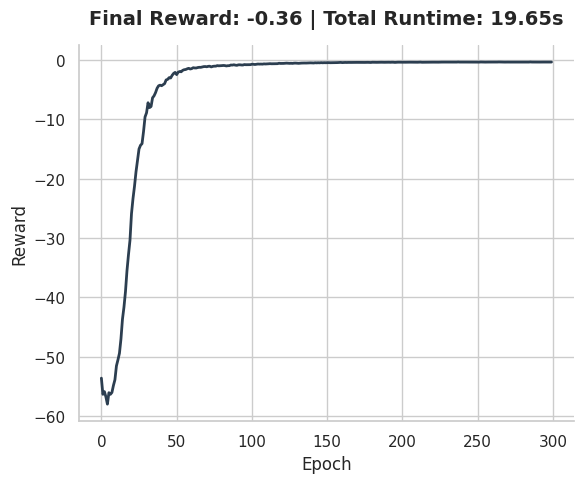

In [8]:
losses = res_dict['metrics']
returns = -losses

sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 5))
plt.plot(returns, color='#2c3e50', linewidth=2)
plt.title(f"Final Reward: {returns[-1]:.2f} | Total Runtime: {time_train_compile:.2f}s", 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.tight_layout()
sns.despine()
plt.show()

## 8. (Optional) Save the Policy Checkpoint

In [9]:
policy_name = "my_traj_tracking_params"

path = LOTF_PATH + "/../checkpoints/policy/" + policy_name
ckptr = PyTreeCheckpointer()
trained_policy_params = res_dict["runner_state"].train_state.params
ckptr.save(path, trained_policy_params)
print(f"Policy saved successfully!")

Policy saved successfully!
